# Load Data

- Load Training (and Test) Data
- Drop columns not required
- Add derived features
- Aggregate data - to be used for training 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import torch 
from functools import reduce

In [6]:
DATA_PATH='/data/workspace_files/iqvia_data/'
# DATA_PATH='/Users/a206602774/Downloads/OneDrive_1_4-14-2021/'


c_all_columns = ['pat_id', 'claimno', 'linenum', 'rectype', 'tos_flag', 'pos', 'conf_num'
               , 'patstat', 'billtype', 'ndc', 'daw', 'formulary', 'dayssup', 'quan', 'proc_cde'
               , 'cpt_mod', 'rev_code', 'srv_unit', 'from_dt', 'to_dt', 'diagprc_ind', 'diag_admit'
               , 'diag1', 'diag2', 'diag3', 'diag4', 'diag5', 'diag6', 'diag7', 'diag8', 'diag9', 'diag10'
               , 'diag11', 'diag12', 'icdprc1', 'icdprc2', 'icdprc3', 'icdprc4', 'icdprc5', 'icdprc6', 'icdprc7'
               , 'icdprc8', 'icdprc9', 'icdprc10', 'icdprc11', 'icdprc12'
               , 'charge', 'allowed', 'paid', 'deductible', 'copay', 'coinsamt', 'cobamt', 'dispense_fee'
               , 'bill_spec', 'rend_spec', 'prscbr_spec', 'att_spec', 'pcp_spec', 'ref_spec'
               , 'ptypeflg', 'sub_tp_cd', 'pmt_st_cd', 'paid_dt']

c_drop_columns = ['linenum','patstat','billtype','daw','dayssup','cpt_mod','diagprc_ind','allowed'
                , 'coinsamt','cobamt','bill_id','rend_id','rend_spec','prscbr_id','att_id'
                , 'att_spec','pcp_id','ref_id','ref_spec','estring','clm_frst','clm_last'
                , 'nbr_clm_lines','enr_frst','enr_last','mon_totl','mxce_fst','mxce_lst'
                , 'patient_id_synth','pat_Zip3','enr_rel','string_type','string_value', 'claimno'
                , 'diag4','diag5','diag6','diag7','diag8','diag9','diag10','diag11','diag12'
                , 'icdprc4','icdprc5','icdprc6','icdprc7','icdprc8','icdprc9','icdprc10','icdprc11','icdprc12'
                , 'grp_indv_cd','mh_cd', 'sub_tp_cd', 'ptypeflg', 'tos_flag', 'rev_code', 'srv_unit'
                , 'pcp_spec', 'charge', 'deductible']
selected_columns = ['pat_id', 'rectype', 'pos', 'conf_num', 'ndc', 'formulary', 'quan', 'proc_cde'
                   , 'from_dt', 'to_dt', 'diag_admit', 'diag1', 'diag2', 'diag3', 'icdprc1'
                   , 'icdprc2', 'icdprc3', 'paid', 'copay', 'dispense_fee', 'bill_spec'
                   , 'prscbr_spec', 'pmt_st_cd', 'paid_dt']
group_by_columns = ['pat_id', 'from_dt', 'to_dt', 'rectype', 'conf_num', 'icdprc1'
                    ,'diag_admit', 'diag1', 'proc_cde', 'bill_spec', 'pos', 'ndc', 'quan'
                    ,'formulary', 'paid_dt', 'pmt_st_cd']
date_columns = ['from_dt', 'to_dt', 'paid_dt']
char_columns = ['pat_id', 'rectype', 'conf_num', 'icdprc1', 'diag_admit', 'diag1'
                , 'proc_cde', 'bill_spec', 'pos', 'ndc', 'formulary', 'pmt_st_cd']

#pat_age_group
#(0) 0 - 10 | (1) 11 - 20 | (2) 21 - 30 | (3) 31-40 | .... () 80 -84....

cat_features = ['rectype', 'icdprc1', 'diag_admit', 'diag1', 'proc_cde', 'bill_spec'
                , 'pos', 'ndc', 'formulary', 'der_sex', ] #pat_age_group
numerical_columns = ['quan', 'paid', 'copay', 'dispense_fee', 'pat_age']
target_columns = ['paid', 'copay', 'dispense_fee']

e_selected_columns = ['der_sex', 'der_yob', 'pat_id', 'pat_state']
e2_selected_columns = ['pat_id', 'mh_cd']

dtype = {}
for column in selected_columns:
    if column in date_columns:
        dtype[column] = 'object'
        pass
    elif column in numerical_columns:
        dtype[column] = 'float64'
    else:
        dtype[column] = 'str'

In [7]:
def custom_fill_na(df):
    for col in df:
        #get dtype for column
        dt = df[col].dtype 
        #check if it is a number
        if dt == int or dt == float:
            df[col].fillna(0, inplace=True)
        else:
            df[col].fillna("", inplace=True)

In [55]:
def load_data():
    # Load Claims_15 data (revisit later)
    claims_15 = pd.read_table(DATA_PATH+"claims_2015.dat", delimiter="|"
                              , usecols = selected_columns
                              , dtype = dtype)
    custom_fill_na(claims_15)
    
    enroll = pd.read_table(DATA_PATH+"enroll_synth.dat",delimiter="|", usecols = e_selected_columns)
    # enroll2 = pd.read_table(DATA_PATH+"enroll2.dat",delimiter="|", usecols = e2_selected_columns)

    # Created aggregate dataset for training
    train = claims_15.groupby(group_by_columns).sum().reset_index()
    # Data type cleanup and calculate derived columns 
    for column in date_columns: 
        train[column] = pd.to_datetime(train[column])
        
    # Merge Dataframes (add enroll2 later)
    data_frames = [train, enroll]
    train = reduce(lambda  left,right: pd.merge(left,right,on=['pat_id'],how='inner'), data_frames)

    # Derived columns 
    train['duration'] = train['to_dt'] - train['from_dt']
    train['pat_age'] = train['to_dt'].dt.year - train['der_yob']
    train['pat_age'].mask(train['pat_age'] > 120, 0, inplace=True)    
    return train

In [62]:
train = load_data()

In [57]:
train

,pat_id,from_dt,to_dt,rectype,conf_num,icdprc1,diag_admit,diag1,proc_cde,bill_spec,...,paid_dt,pmt_st_cd,paid,copay,dispense_fee,der_sex,der_yob,pat_state,duration,pat_age
0,0309AAAAAAAABEUP,2015-01-02,2015-01-02,M,,,,7391,98941,CHIRO,...,2015-02-01,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
1,0309AAAAAAAABEUP,2015-01-05,2015-01-05,M,,,,7391,98941,CHIRO,...,2015-02-04,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
2,0309AAAAAAAABEUP,2015-01-20,2015-01-20,M,,,,4770,95117,ALLERGY,...,2015-02-19,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
3,0309AAAAAAAABEUP,2015-02-10,2015-02-10,M,,,,4770,95117,ALLERGY,...,2015-03-12,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
4,0309AAAAAAAABEUP,2015-03-03,2015-03-03,M,,,,4770,95117,ALLERGY,...,2015-04-02,P,0.00,0.0,0.0,F,1996.0,MN,0 days,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647078,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,80050,OTHR_SPC,...,2015-12-06,P,23.75,0.0,0.0,F,1985.0,TX,0 days,30.0
647079,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,80061,OTHR_SPC,...,2015-12-06,P,10.05,0.0,0.0,F,1985.0,TX,0 days,30.0
647080,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,83036,OTHR_SPC,...,2015-12-06,P,7.28,0.0,0.0,F,1985.0,TX,0 days,30.0
647081,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,84436,OTHR_SPC,...,2015-12-06,P,5.15,0.0,0.0,F,1985.0,TX,0 days,30.0


In [58]:
train[numerical_columns + ['pat_age']].describe()

,quan,paid,copay,dispense_fee,pat_age
count,647083.000000,647083.000000,647083.000000,647083.000000,646125.000000
mean,17.864065,108.538459,2.466423,0.056661,40.054793
std,117.395845,1348.420709,74.449439,0.386681,21.468869
min,-30.000000,-714.250000,-1717.580000,-1.500000,-1.000000
25%,0.000000,0.040000,0.000000,0.000000,23.000000
50%,0.000000,13.510000,0.000000,0.000000,44.000000
75%,15.000000,60.000000,0.000000,0.000000,57.000000
max,21330.000000,709682.550000,20650.000000,18.000000,81.000000


In [70]:
train[char_columns].describe()

,pat_id,rectype,conf_num,icdprc1,diag_admit,diag1,proc_cde,bill_spec,pos,ndc,formulary,pmt_st_cd
count,647083,647083,647083,647083,647083,647083,647083,647083,647083,647083,647083,647083
unique,18927,6,1372,220,661,9767,5477,64,39,10465,5,2
top,pg03AAAAAAHMWUBJ,A,,,,,,,11,,,P
freq,1195,266253,630453,645208,643220,189869,209851,207257,220673,457907,542480,646961


In [59]:
def find_outliers(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x<floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values

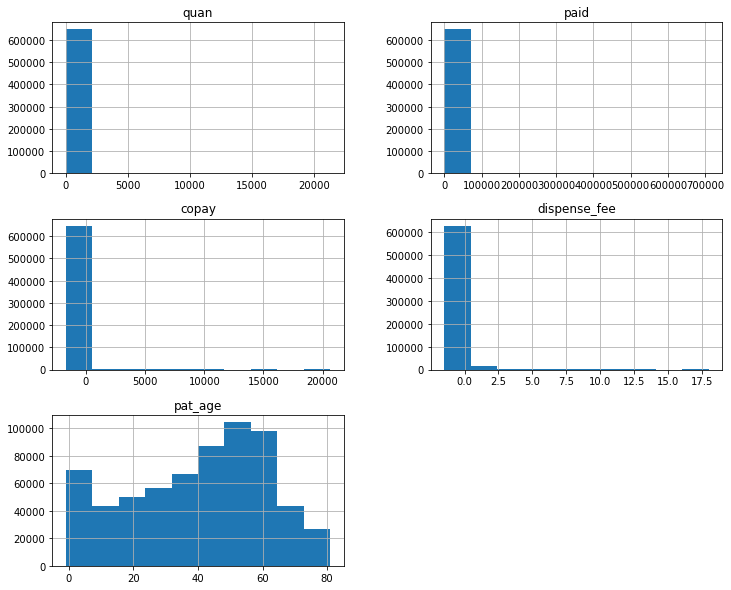

In [60]:
train[numerical_columns + ['pat_age']].hist(figsize=(12,10))
plt.show()

74624
56574
30638
7441
0


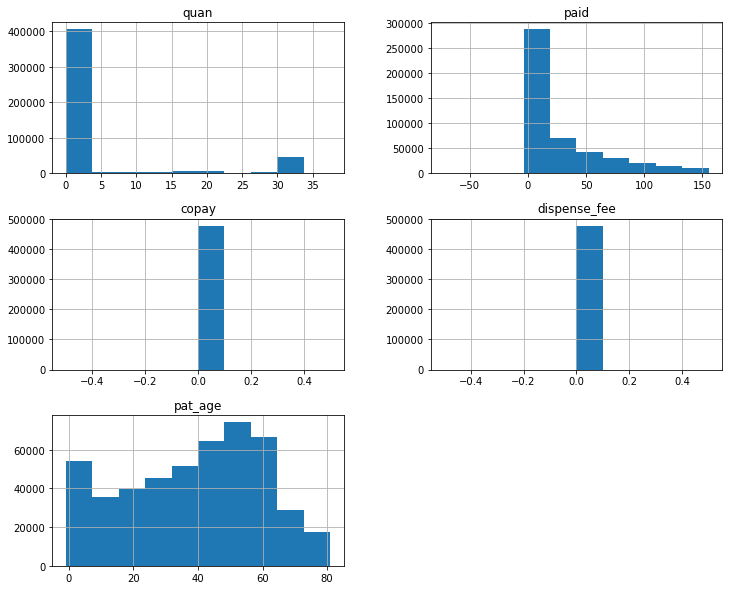

In [61]:
 
 # Should we drop outliers? 
 for column in numerical_columns: 
    paid_indices, paid_values = find_outliers(train[column])
    print(len(paid_indices))
    train.drop(paid_indices, axis=0, inplace=True)

train[numerical_columns + ['pat_age']].hist(figsize=(12,10))

# Scale Numerical Features

In [63]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

scaler = QuantileTransformer(n_quantiles=10, random_state=0,  output_distribution='normal')

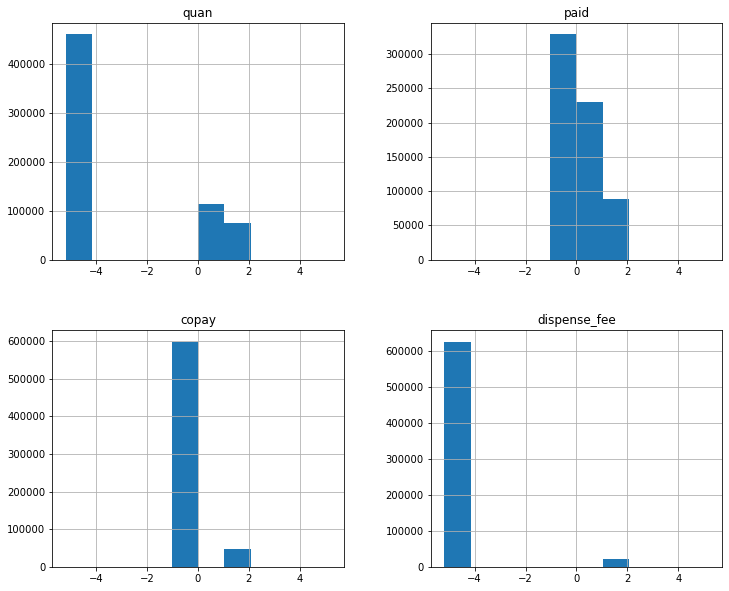

In [64]:
for column in numerical_columns: 
    train[column] = scaler.fit_transform(train[column].values.reshape(-1,1))
    price = train[column]


train[numerical_columns].hist(figsize=(12,10))

# One Hot Encoding of Categorical Variables

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#Information: https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
# For Multiple Embedding Layers

In [0]:
cat_features = ['rectype', 'icdprc1', 'diag_admit', 'diag1', 'proc_cde', 'bill_spec'
                , 'pos', 'ndc', 'formulary', 'der_sex', 'der_yob']

In [65]:
train_copy = train.copy(deep=True)

dummies = pd.get_dummies(train_copy['rectype'], prefix='rectype')
train_copy = pd.concat([train_copy,dummies], axis = 1)


In [66]:
train_copy

,pat_id,from_dt,to_dt,rectype,conf_num,icdprc1,diag_admit,diag1,proc_cde,bill_spec,...,der_yob,pat_state,duration,pat_age,rectype_,rectype_A,rectype_F,rectype_M,rectype_P,rectype_S
0,0309AAAAAAAABEUP,2015-01-02,2015-01-02,M,,,,7391,98941,CHIRO,...,1996.0,MN,0 days,19.0,0,0,0,1,0,0
1,0309AAAAAAAABEUP,2015-01-05,2015-01-05,M,,,,7391,98941,CHIRO,...,1996.0,MN,0 days,19.0,0,0,0,1,0,0
2,0309AAAAAAAABEUP,2015-01-20,2015-01-20,M,,,,4770,95117,ALLERGY,...,1996.0,MN,0 days,19.0,0,0,0,1,0,0
3,0309AAAAAAAABEUP,2015-02-10,2015-02-10,M,,,,4770,95117,ALLERGY,...,1996.0,MN,0 days,19.0,0,0,0,1,0,0
4,0309AAAAAAAABEUP,2015-03-03,2015-03-03,M,,,,4770,95117,ALLERGY,...,1996.0,MN,0 days,19.0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647078,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,80050,OTHR_SPC,...,1985.0,TX,0 days,30.0,0,1,0,0,0,0
647079,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,80061,OTHR_SPC,...,1985.0,TX,0 days,30.0,0,1,0,0,0,0
647080,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,83036,OTHR_SPC,...,1985.0,TX,0 days,30.0,0,1,0,0,0,0
647081,s149AAAAAOLPBWLQ,2015-11-06,2015-11-06,A,,,,Z0000,84436,OTHR_SPC,...,1985.0,TX,0 days,30.0,0,1,0,0,0,0


In [71]:
dx_lookup = pd.read_table(DATA_PATH+"pp_dx_lookup.dat",delimiter="|")

In [72]:
dx_lookup

,dx_cd,diagnosis,diagnosis_desc,diag_vers_typ_id
0,7889,788.9,OTHER SYMPTOMS INVOLVING URINARY SYSTEM,1
1,78053,780.53,"HYPERSOMNIA WITH SLEEP APNEA, UNSPECIFIED",1
2,70710,707.10,UNSPECIFIED ULCER OF LOWER LIMB,1
3,78902,789.02,"ABDOMINAL PAIN, LEFT UPPER QUADRANT",1
4,2948,294.8,OTHER PERSISTENT MENTAL DISORDERS DUE TO CONDI...,1
...,...,...,...,...
95196,V8052,V80.52,OCCUPANT OF ANIMAL-DRAWN VEHICLE INJURED IN CO...,2
95197,T505X2S,T50.5X2S,"POISONING BY APPETITE DEPRESSANTS, INTENTIONAL...",2
95198,B171,B17.1,ACUTE HEPATITIS C,2
95199,T50Z16S,T50.Z16S,"UNDERDOSING OF IMMUNOGLOBULIN, SEQUELA",2
